Available as executable or viewable Jupyter Notebook:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/HIL-HK/lets-plot-examples/master?filepath=demo%2Fmalnutrition.ipynb)

[<img alt="nbviewer" src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.png" width="109" height="20">](https://nbviewer.jupyter.org/github/HIL-HK/lets-plot-examples/blob/master/demo/malnutrition.ipynb)


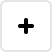
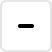
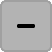
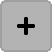
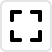
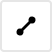
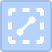

In [1]:
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from lets_plot import *; LetsPlot.setup_html()

# Malnutrition in the World

Data comes from [here](https://www.kaggle.com/ruchi798/malnutrition-across-the-globe).

In [2]:
cwa_df = pd.read_csv('https://raw.githubusercontent.com/HIL-HK/lets-plot-examples/master/data/malnutrition/country_wise_average.csv')

In [3]:
me_df = pd.read_csv('https://raw.githubusercontent.com/HIL-HK/lets-plot-examples/master/data/malnutrition/malnutrition_estimates.csv')
me_df = me_df.sort_values(by='Year', ascending=False).drop_duplicates(subset='Country')
me_df = me_df[['Country', 'ISO code', 'LDC', 'LIFD', 'LLDC or SID2']]

In [4]:
df = cwa_df.merge(me_df, on='Country')
df.Country = df.Country.apply(lambda country_name: country_name.capitalize())

### A Bit of Correlation Analysis

Let's look at the correlation coefficients of random variables that correspond to dataframe columns.

In [5]:
corr_df = df.corr().dropna(how='all').dropna(axis=1, how='all')
corr_df = corr_df.stack().to_frame().reset_index()
corr_df.columns = ['feature_1', 'feature_2', 'corr']
corr_df['features_pair'] = '(' + corr_df.feature_1 + ', ' + corr_df.feature_2 + ')'

ggplot() + \
    geom_point(aes(x='feature_1', y='feature_2', color='features_pair', fill='corr'), data=corr_df, shape=22, size=25) + \
    scale_color_gradient(name='', low='white', high='white') + \
    scale_fill_gradient(name='Correlation coefficient', low='#fc8d59', high='#91cf60', limits=[-1, 1]) + \
    coord_fixed(ratio=1) + \
    ggtitle('Correlation Matrix') + \
    ggsize(1000, 700) + \
    theme(axis_title='blank', axis_ticks='blank', axis_line='blank')

In [6]:
cat_cols = ['Income Classification', 'LDC', 'LIFD', 'LLDC or SID2']
num_cols = ['U5 Population (\'000s)']
features = cat_cols + num_cols
targets = ['Severe Wasting', 'Wasting', 'Overweight', 'Stunting', 'Underweight']
targets = list(df[targets].isnull().sum().sort_values().keys())

for target in targets:
    df_train = df[~df[target].isnull()]
    df_test = df[df[target].isnull()]
    X, y = df_train[features], df_train[target]
    X_test = df_test[features]

    parameters = dict(n_estimators=[10, 20, 30, 60], max_depth=[1, 2, 3, 4, 5, 6, 7])
    model = GridSearchCV(RandomForestRegressor(), parameters)
    model.fit(X, y)
    y_pred = model.predict(X_test)
    
    df[target] = df[target].fillna(pd.Series(y_pred, index=X_test.index))

    features = features + [target]

In [7]:
def plot_world_decomposition(df, target):
    target_abs = target + ' ABS'
    target_bh = target + ' BH'

    df_copy = df.copy()
    df_copy[target_abs] = df_copy[target] * df_copy['U5 Population (\'000s)'] / 100
    df_copy = df_copy.sort_values(by=target_abs, ascending=False)
    df_copy[target_bh] = df_copy[target_abs].cumsum() < df_copy[target_abs].sum() / 2
    df_copy.loc[df_copy[target_bh].ne(True).idxmax(), target_bh] = True
    df_copy[target_bh] = df_copy[target_bh].apply(lambda r: 'Bigger half' if r else 'Smaller half')

    sifted_df = df_copy[['ISO code', target_abs, target_bh]]
    world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))[['iso_a3', 'geometry', 'name']]
    merged_df = gpd.GeoDataFrame(sifted_df.merge(world_gdf, how='right', left_on='ISO code', right_on='iso_a3'))
    merged_df[target_abs] = merged_df[target_abs].fillna(0)
    merged_df[target_bh] = merged_df[target_bh].fillna('Not in statistics')

    return ggplot() + \
        geom_polygon(aes(fill=target_bh, color=target_abs, size='name', alpha=target_abs), data=merged_df) + \
        scale_color_gradient(name=target, low='black', high='black') + \
        scale_size(name='Country', range=[.3, .3]) + \
        scale_alpha(name=target, range=[.6, 1]) + \
        scale_fill_manual(name=target, values=['#ca0020', '#0571b0', '#bababa']) + \
        ggtitle('%s in the World' % target) + \
        ggsize(1000, 750) + \
        theme(legend_position='none', axis_title='blank', axis_text='blank', axis_ticks='blank', axis_line='blank')

### Choropleth Maps

For each map, the total of children with this disorder in red countries equals to that in blue countries.

In [8]:
plot_world_decomposition(df, 'Severe Wasting')

In [9]:
plot_world_decomposition(df, 'Wasting')

In [10]:
plot_world_decomposition(df, 'Overweight')

In [11]:
plot_world_decomposition(df, 'Stunting')

In [12]:
plot_world_decomposition(df, 'Underweight')